In [1]:
!pip install pennylane
from IPython.display import clear_output
clear_output()


In [2]:
import pennylane as qml
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from sklearn.preprocessing import OneHotEncoder
import math
import threading


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [3]:
# Standard Libraries
import os
import cv2


# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset path
DATASET_PATH = "/content/drive/MyDrive/COVID-19 Lung CT Scans_FULL"
COVID_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/COVID-19 Lung CT Scans_FULL/COVID-19")
NONCOVID_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/COVID-19 Lung CT Scans_FULL/Non-COVID-19")


In [4]:
# Check first few image shapes (without resizing)
def check_original_shapes(folder, label_name, num_samples=5):
    print(f"\nChecking {label_name} images:")
    count = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            print(f"{filename}: {img.shape}")  # (height, width)
            count += 1
        if count >= num_samples:
            break

# Show shapes
check_original_shapes(COVID_PATH, "COVID-19")
check_original_shapes(NONCOVID_PATH, "Non-COVID-19")


Checking COVID-19 images:
COVID-19_6435.png: (512, 512)
COVID-19_6553.png: (512, 512)
COVID-19_6445.png: (512, 512)
COVID-19_6437.png: (512, 512)
COVID-19_6485.png: (512, 512)

Checking Non-COVID-19 images:
Non-COVID-19_163.png: (512, 512)
Non-COVID-19_067.png: (512, 512)
Non-COVID-19_040.png: (512, 512)
Non-COVID-19_063.png: (512, 512)
Non-COVID-19_103.png: (512, 512)


In [5]:

def load_images_from_folder(folder_path, label, img_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

# Load COVID and Non-COVID images
covid_images, covid_labels = load_images_from_folder(COVID_PATH, 1)
noncovid_images, noncovid_labels = load_images_from_folder(NONCOVID_PATH, 0)

# Combine and convert to numpy arrays
X = np.array(covid_images + noncovid_images)
y = np.array(covid_labels + noncovid_labels)

# Expand dimensions for CNN
X = X.reshape(-1, 64, 64, 1) / 255.0

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [21]:
# Resize images to 32x32 for Amplitude Embedding (1024 features for 10 qubits)
# Assuming X_train and X_test are already loaded and preprocessed as numpy arrays
X_train_resized = X_train.reshape(-1, 64, 64) # Remove the channel dimension for resizing
X_test_resized = X_test.reshape(-1, 64, 64)

# Use cv2.resize for resizing
X_train_resized = np.array([cv2.resize(img, (32, 32)) for img in X_train_resized])
X_test_resized = np.array([cv2.resize(img, (32, 32)) for img in X_test_resized])

# Flatten the resized images to a 1D vector of size 1024
X_train_flat = X_train_resized.reshape(-1, 32*32)
X_test_flat = X_test_resized.reshape(-1, 32*32)

print(f"Resized and flattened training data shape: {X_train_flat.shape}")
print(f"Resized and flattened testing data shape: {X_test_flat.shape}")

Resized and flattened training data shape: (6752, 1024)
Resized and flattened testing data shape: (1688, 1024)


In [77]:
import pennylane as qml
import numpy as np

# Set up the device with 11 qubits (10 for features, 1 for ancilla)
dev = qml.device("default.qubit", wires=11)

# Define the quantum circuit
@qml.qnode(dev, interface='torch')  # Use torch interface for PyTorch compatibility
def quantum_circuit(features, phis):
    # Amplitude encoding with 1024 features → 10 qubits
    qml.AmplitudeEmbedding(features=features, wires=range(10), normalize=True, pad_with=0)

    # First Convolution
    qml.CRY(phi=phis[0], wires=[9, 8])
    qml.CRY(phi=phis[1], wires=[8, 7])
    qml.CRY(phi=phis[2], wires=[7, 6])
    qml.CRY(phi=phis[3], wires=[6, 9])
    qml.CRY(phi=phis[4], wires=[5, 4])
    qml.CRY(phi=phis[5], wires=[4, 3])
    qml.CRY(phi=phis[6], wires=[3, 2])
    qml.CRY(phi=phis[7], wires=[2, 1])
    qml.CRY(phi=phis[8], wires=[1, 0])
    qml.CRY(phi=phis[9], wires=[0, 5])
    qml.Barrier()

    # First Pooling
    qml.CRZ(phi=phis[10], wires=[9, 8])
    qml.X(wires=9)
    qml.CRX(phi=phis[11], wires=[9, 8])
    qml.CRZ(phi=phis[10], wires=[5, 4])
    qml.X(wires=5)
    qml.CRX(phi=phis[11], wires=[5, 4])
    qml.Barrier()

    # Activations 1
    for w, phi in zip([0, 1, 2, 6, 7, 8], phis[12:18]):
        qml.Hadamard(wires=w)
        qml.RZ(phi=phi, wires=w)
    qml.Barrier()

    # Second Convolution
    qml.CRY(phi=phis[18], wires=[8, 7])
    qml.CRY(phi=phis[19], wires=[7, 6])
    qml.CRY(phi=phis[20], wires=[6, 8])
    qml.CRY(phi=phis[21], wires=[4, 3])
    qml.CRY(phi=phis[22], wires=[3, 2])
    qml.CRY(phi=phis[23], wires=[2, 4])
    qml.Barrier()

    # Second Pooling
    qml.CRZ(phi=phis[24], wires=[8, 7])
    qml.X(wires=8)
    qml.CRX(phi=phis[25], wires=[8, 7])
    qml.CRZ(phi=phis[24], wires=[4, 3])
    qml.X(wires=4)
    qml.CRX(phi=phis[25], wires=[4, 3])
    qml.Barrier()

    # Activations 2
    for w, phi in zip([0, 1, 6, 7], phis[26:30]):
        qml.Hadamard(wires=w)
        qml.RZ(phi=phi, wires=w)
    qml.Barrier()

    # Third Convolution
    qml.CRY(phi=phis[30], wires=[7, 6])
    qml.CRY(phi=phis[31], wires=[6, 7])
    qml.CRY(phi=phis[32], wires=[1, 0])
    qml.CRY(phi=phis[33], wires=[0, 1])
    qml.Barrier()

    # Third Pooling
    qml.CRZ(phi=phis[34], wires=[7, 6])
    qml.X(wires=7)
    qml.CRX(phi=phis[35], wires=[7, 6])
    qml.CRZ(phi=phis[34], wires=[1, 0])
    qml.X(wires=1)
    qml.CRX(phi=phis[35], wires=[1, 0])

    # Single ancilla qubit (wire 10)
    qml.CNOT(wires=[0, 10])   # connect final feature qubit to ancilla

    # Return expectation value for binary classification
    return qml.expval(qml.PauliZ(10))

In [80]:
num_feature_qubits = 10
num_features = 2 ** num_feature_qubits  # 1024

# Example: normalize a random input
features = np.random.rand(num_features)
features = features / np.linalg.norm(features)

In [81]:
num_phis = 36   # The quantum circuit uses parameters up to phis[35], so we need 36 parameters
phis = np.random.uniform(-np.pi, np.pi, size=num_phis)
result = quantum_circuit(features, phis)
print(result)

tensor(-0.1551, dtype=torch.float64)


 0: ─╭|Ψ⟩────────────────────────────────────────────╭RY(0.09)─╭●─────────||────────────── ···
 1: ─├|Ψ⟩──────────────────────────────────╭RY(1.99)─╰●────────│──────────||────────────── ···
 2: ─├|Ψ⟩───────────────────────╭RY(-0.78)─╰●──────────────────│──────────||────────────── ···
 3: ─├|Ψ⟩────────────╭RY(0.74)──╰●─────────────────────────────│──────────||────────────── ···
 4: ─├|Ψ⟩─╭RY(-1.47)─╰●────────────────────────────────────────│──────────||─╭RZ(-2.80)─── ···
 5: ─├|Ψ⟩─╰●───────────────────────────────────────────────────╰RY(2.55)──||─╰●──────────X ···
 6: ─├|Ψ⟩───────────────────────╭RY(-2.73)─╭●─────────────────────────────||────────────── ···
 7: ─├|Ψ⟩────────────╭RY(-1.02)─╰●─────────│──────────────────────────────||────────────── ···
 8: ─├|Ψ⟩─╭RY(-2.41)─╰●────────────────────│──────────────────────────────||─╭RZ(-2.80)─── ···
 9: ─╰|Ψ⟩─╰●───────────────────────────────╰RY(2.26)──────────────────────||─╰●──────────X ···
10: ──────────────────────────────────────────────

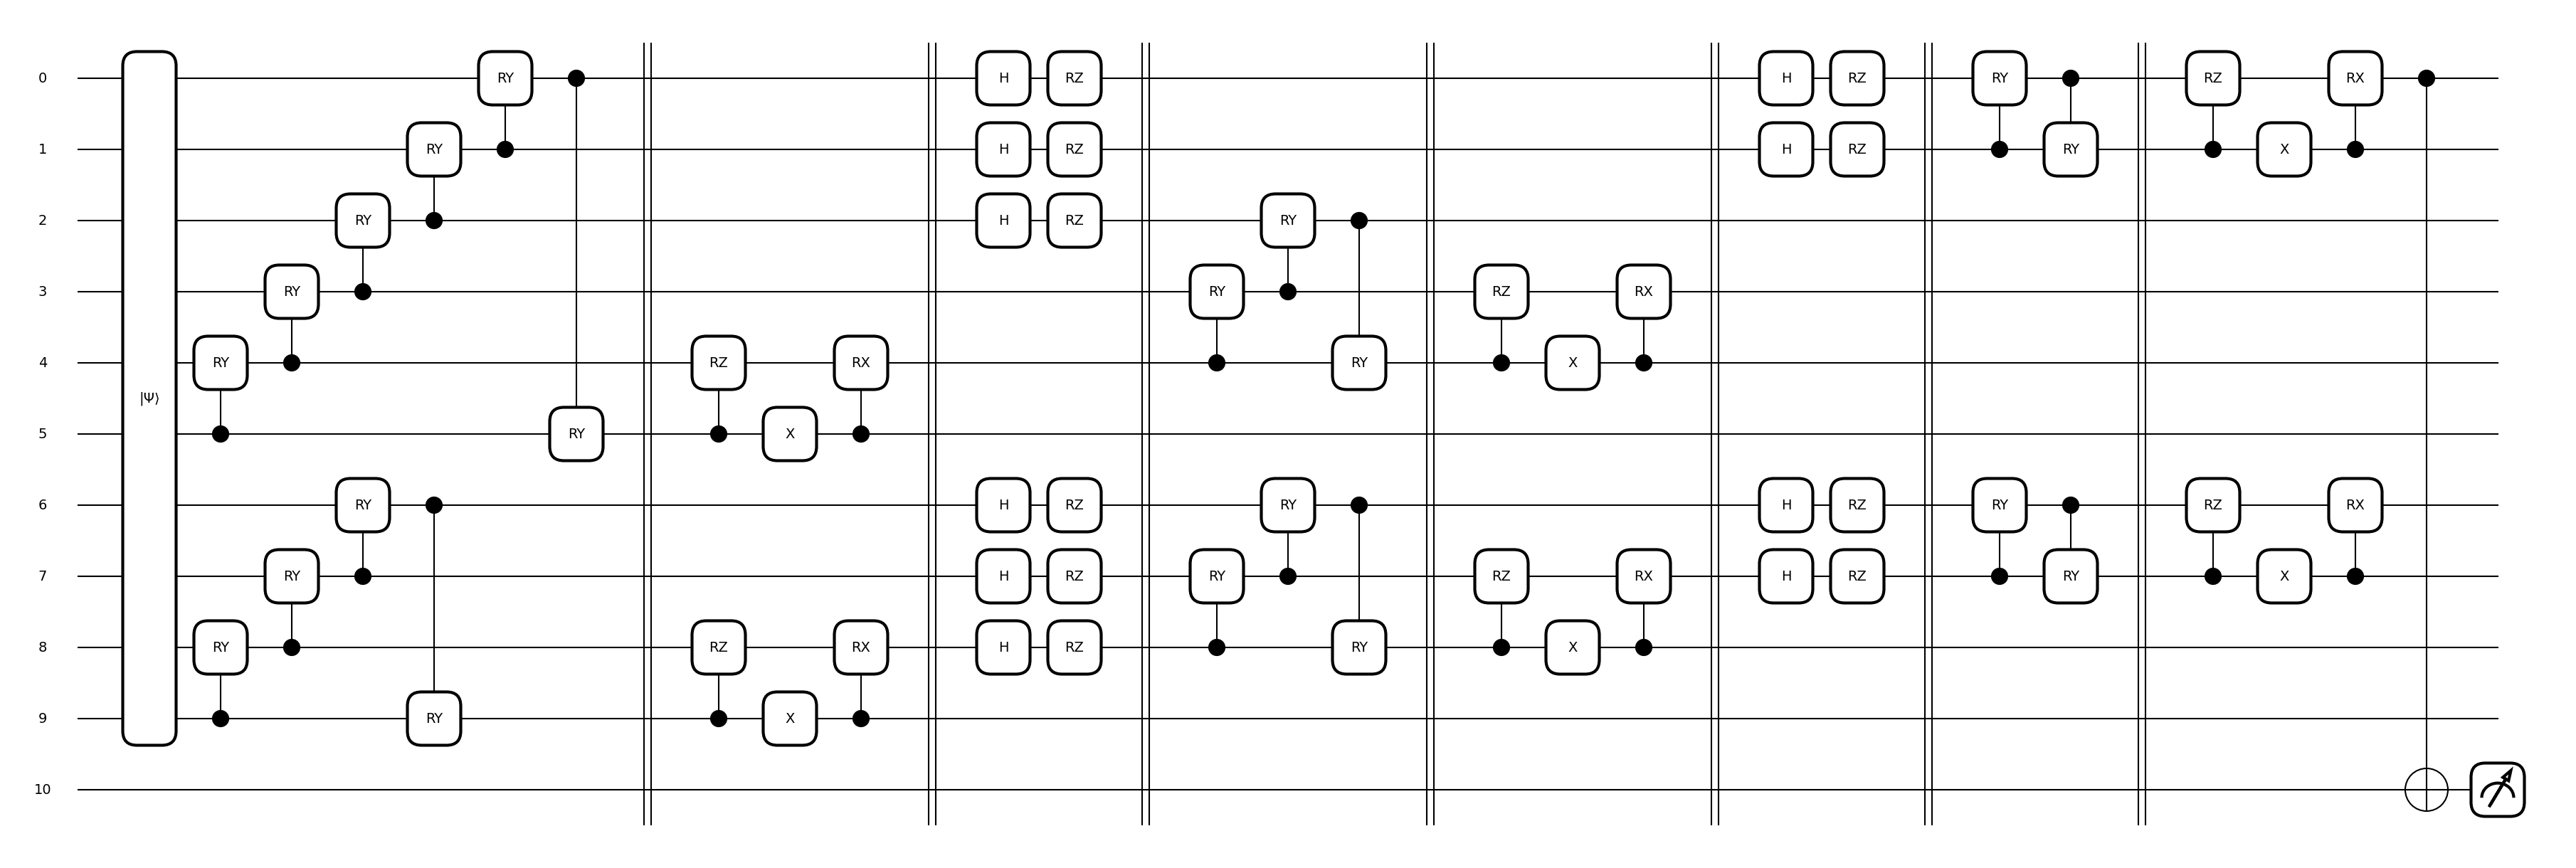

In [82]:
import matplotlib.pyplot as plt

# Random normalized feature vector (512 amplitudes)
features = np.random.rand(1024)
features = features / np.linalg.norm(features)

# Number of parameters
num_phis = 36
phis = np.random.uniform(-np.pi, np.pi, size=num_phis)

# --- ASCII circuit diagram ---
drawer = qml.draw(quantum_circuit)
print(drawer(features, phis))

# --- Matplotlib circuit diagram ---
fig, ax = qml.draw_mpl(quantum_circuit)(features, phis)
plt.show()

In [84]:
class QCNN(torch.nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        # Initialize the trainable quantum circuit parameters with uniform distribution
        torch.random.manual_seed(42)
        # Based on the quantum_circuit, we need 36 parameters (phis[0] to phis[35])
        self.phis = torch.nn.Parameter(torch.empty(36)) # Initialize with 36 parameters
        torch.nn.init.uniform_(self.phis, a=-np.pi, b=np.pi)

    def forward(self, x):
        # Ensure batch dimension
        if x.dim() == 1:
            x = x.unsqueeze(0)

        # Ensure the features are normalized for Amplitude Embedding
        # Normalize batches (assuming input is now always 2D due to unsqueeze)
        x_normalized = x / torch.linalg.norm(x, dim=1, keepdim=True)

        # Call the quantum circuit with PyTorch tensors
        # The quantum_circuit with interface='torch' handles batches directly
        q_output = quantum_circuit(features=x_normalized, phis=self.phis)

        # --- Diagnostic Print Statement ---
        print(f"Quantum circuit output requires_grad: {q_output.requires_grad}")
        # ----------------------------------


        # The output from qml.qnode with interface='torch' is a PyTorch tensor with requires_grad=True
        # It will have shape (batch_size,) for scalar expectation values
        # We need to ensure it's shape (batch_size, 1) for BCEWithLogitsLoss if targets are (batch_size, 1)
        if q_output.dim() == 1:
            q_output = q_output.unsqueeze(1)

        return q_output

In [85]:
model = QCNN()
total_params = sum(p.numel() for p in model.parameters())
print(total_params)


36


In [86]:

# Set up the model, optimizer, and loss function
model = QCNN()
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()  # Use NLLLoss since output is probabilities

In [87]:

def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy


In [88]:
import torch
from torch.optim import Adam
from sklearn.model_selection import train_test_split

# ---------------------------
# Data Preparation
# ---------------------------
# Amplitude embedding for 10 qubits → 2^10 = 1024 features
# Ensure X_train_flat and X_test_flat are shape (N, 1024)

# Split training data into train + validation (80/20 split)
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train_flat, y_train, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_tensor, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_tensor, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ---------------------------
# Training Setup
# ---------------------------
phi_history = []
loss_history = []
val_loss_history = []
accuracy_history = [0.0]
val_accuracy_history = [0.0]

# Early Stopping params
patience = 10
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Optimizer and Loss
optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()   # <-- For binary classification (no sigmoid in forward)

# Training loop
num_epochs = 10
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):

    if early_stop:
        print("Early stopping triggered.")
        break

    epoch_loss = 0
    model.train()

    # Keep record of phi values
    phi_history.append(model.phis.clone().detach().cpu().numpy())

    # Shuffle the training data
    torch.manual_seed(seed + epoch)
    permutation = torch.randperm(X_train_tensor.size()[0])
    X_train_tensor = X_train_tensor[permutation]
    y_train_tensor = y_train_tensor[permutation]

    # Mini-batch training
    for i in range(0, len(X_train_tensor), batch_size):
        x_batch = X_train_tensor[i:i + batch_size].to(device)
        y_batch = y_train_tensor[i:i + batch_size].to(device)

        optimizer.zero_grad()

        # Forward pass (model returns logits directly) - Pass PyTorch tensor directly
        outputs = model(x_batch).to(device) # Pass the entire batch

        # Ensure y_batch has the correct shape (batch_size, 1)
        if y_batch.dim() == 1:
            y_batch = y_batch.unsqueeze(1)

        # Compute BCE loss
        loss = loss_fn(outputs, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # ---------------------------
    # Compute Train Accuracy
    # ---------------------------
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_tensor.to(device)) # Pass the entire training data
        preds = (torch.sigmoid(train_outputs) > 0.5).float()
        # Ensure y_train_tensor has shape (N, 1) for comparison
        if y_train_tensor.dim() == 1:
             y_train_tensor = y_train_tensor.unsqueeze(1)
        train_accuracy = (preds == y_train_tensor.to(device)).sum().item() / len(y_train_tensor)

        accuracy_history.append(train_accuracy)
        loss_history.append(loss.item())

    # ---------------------------
    # Compute Validation Loss & Accuracy
    # ---------------------------
    with torch.no_grad():
        val_outputs = model(X_val_tensor.to(device)) # Pass the entire validation data
        # Ensure y_val_tensor has shape (N, 1) for loss calculation
        if y_val_tensor.dim() == 1:
             y_val_tensor = y_val_tensor.unsqueeze(1)
        val_loss = loss_fn(val_outputs, y_val_tensor.to(device)).item()

        preds_val = (torch.sigmoid(val_outputs) > 0.5).float()
         # Ensure y_val_tensor has shape (N, 1) for comparison
        if y_val_tensor.dim() == 1:
             y_val_tensor = y_val_tensor.unsqueeze(1)
        val_accuracy = (preds_val == y_val_tensor.to(device)).sum().item() / len(y_val_tensor)

        val_accuracy_history.append(val_accuracy)
        val_loss_history.append(val_loss)

    # Print metrics
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss / (len(X_train_tensor) / batch_size):.4f}, "
          f"Accuracy: {train_accuracy:.4f}  |  "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # ---------------------------
    # Early Stopping Check
    # ---------------------------
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        early_stop = True

print("Training finished.")

Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum circuit output requires_grad: True
Quantum cir

In [90]:
from collections import defaultdict

# Initialize a dictionary to store counts per class
class_correct = defaultdict(int)
class_total = defaultdict(int)

model.eval()

# List of class labels (binary classification: 0 and 1)
class_labels = [0, 1]

# Ensure X_test_tensor and y_test_tensor are on the correct device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


with torch.no_grad():
    # Forward pass (model returns logits directly) - Pass PyTorch tensor directly
    test_outputs = model(X_test_tensor).squeeze()

    # Apply sigmoid for binary classification
    probs = torch.sigmoid(test_outputs)
    predicted = (probs >= 0.5).float()

    # Overall accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"\n✅ Overall Test Accuracy: {accuracy:.4f}\n")

    # Calculate accuracy per class
    for i in range(len(y_test_tensor)):
        label = int(y_test_tensor[i].item())
        pred = int(predicted[i].item())

        if label == pred:
            class_correct[label] += 1
        class_total[label] += 1

# Print accuracy for each class
for label in class_labels:
    if class_total[label] > 0:
        class_accuracy = class_correct[label] / class_total[label]
        print(f"🎯 Accuracy for class {label}: {class_accuracy:.4f} "
              f"({class_correct[label]}/{class_total[label]})")
    else:
        print(f"No samples found for class {label}.")

Quantum circuit output requires_grad: False

✅ Overall Test Accuracy: 0.8886

🎯 Accuracy for class 0: 0.0000 (0/188)
🎯 Accuracy for class 1: 1.0000 (1500/1500)


In [92]:
# Evaluation on the test set
test_outs = None
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze().to(device) # Pass PyTorch tensor directly
    test_outs = test_outputs
    # For binary classification, predict based on the logit being > 0
    predicted = (test_outputs > 0).float().cpu() # Compare logits to 0, cast to float, and move to CPU

    # Calculate overall accuracy
    accuracy = (predicted == y_test_tensor.cpu()).sum().item() / len(y_test_tensor) # Move y_test_tensor to CPU for comparison
    print(f"Test Accuracy: {accuracy:.4f}")

Quantum circuit output requires_grad: False
Test Accuracy: 0.8886
